In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
# move to root directory
while os.path.basename(os.getcwd()) != "reward-network-iii":
    os.chdir("..")

In [3]:
files = [
    'data/24_02_04/model/mode_nodes_more_steps_0.csv',
    'data/24_02_04/model/mode_nodes_more_steps_1.csv',
    'data/24_02_04/model/mode_nodes_more_steps_2.csv',
]

dfs = []
for s, file in enumerate(files):
    df = pd.read_csv(file)
    df['seed'] = s
    dfs.append(df)
df = pd.concat(dfs)

In [4]:
df[['average reward', 'average level']] = df[['test_avg_reward_all_envs', 'test_avg_level_all_envs']]

In [5]:
df = df[['episode', 'seed', 'average reward', 'average level']]
df = df.dropna()
df['seed'] = df['seed'].astype(str)

In [6]:
df_myopic = pd.read_json('data/23_11_30/solution_test__myopic.json')
df_random = pd.read_json('data/23_11_30/solution_test__random.json')
df_take_loss = pd.read_json('data/23_11_30/solution_test__take_loss.json')


ref_max_level = {
    'myopic': df_myopic['max_level'].mean(),
    'random': df_random['max_level'].mean(),
    'take_loss': df_take_loss['max_level'].mean(),
}
ref_total_reward = {
    'myopic': df_myopic['total_reward'].mean(),
    'random': df_random['total_reward'].mean(),
    'take_loss': df_take_loss['total_reward'].mean(),
}

In [7]:
# smooth the data group by seed
df = df.groupby('seed').rolling(10, center=True).mean().reset_index()
df = df.dropna()

Text(5000, 2474.8, 'take loss')

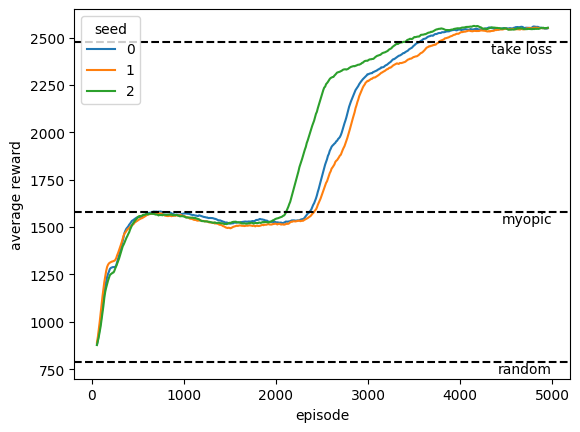

In [8]:
sns.lineplot(data=df, x="episode", y="average reward", hue="seed")
plt.axhline(ref_total_reward['myopic'], ls='--', label='myopic', color='black')
plt.text(5000, ref_total_reward['myopic'], 'myopic', ha='right', va='top')
plt.axhline(ref_total_reward['random'], ls='--', label='random', color='black')
plt.text(5000, ref_total_reward['random'], 'random', ha='right', va='top')
plt.axhline(ref_total_reward['take_loss'], ls='--', label='take loss', color='black')
plt.text(5000, ref_total_reward['take_loss'], 'take loss', ha='right', va='top')


Text(5000, 2.885, 'take loss')

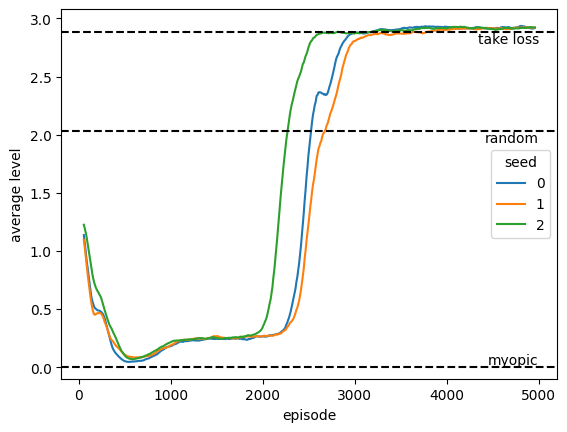

In [9]:
sns.lineplot(data=df, x="episode", y="average level", hue="seed")
plt.axhline(ref_max_level['myopic'], ls='--', label='myopic', color='black')
plt.text(5000, ref_max_level['myopic'], 'myopic', ha='right', va='bottom')
plt.axhline(ref_max_level['random'], ls='--', label='random', color='black')
plt.text(5000, ref_max_level['random'], 'random', ha='right', va='top')
plt.axhline(ref_max_level['take_loss'], ls='--', label='take loss', color='black')
plt.text(5000, ref_max_level['take_loss'], 'take loss', ha='right', va='top')

In [10]:
# each run toook 5 min on a RTX 5000
# In this time the algorithm played tested 5000 different solutions each on 1000 different networks.